# DATA

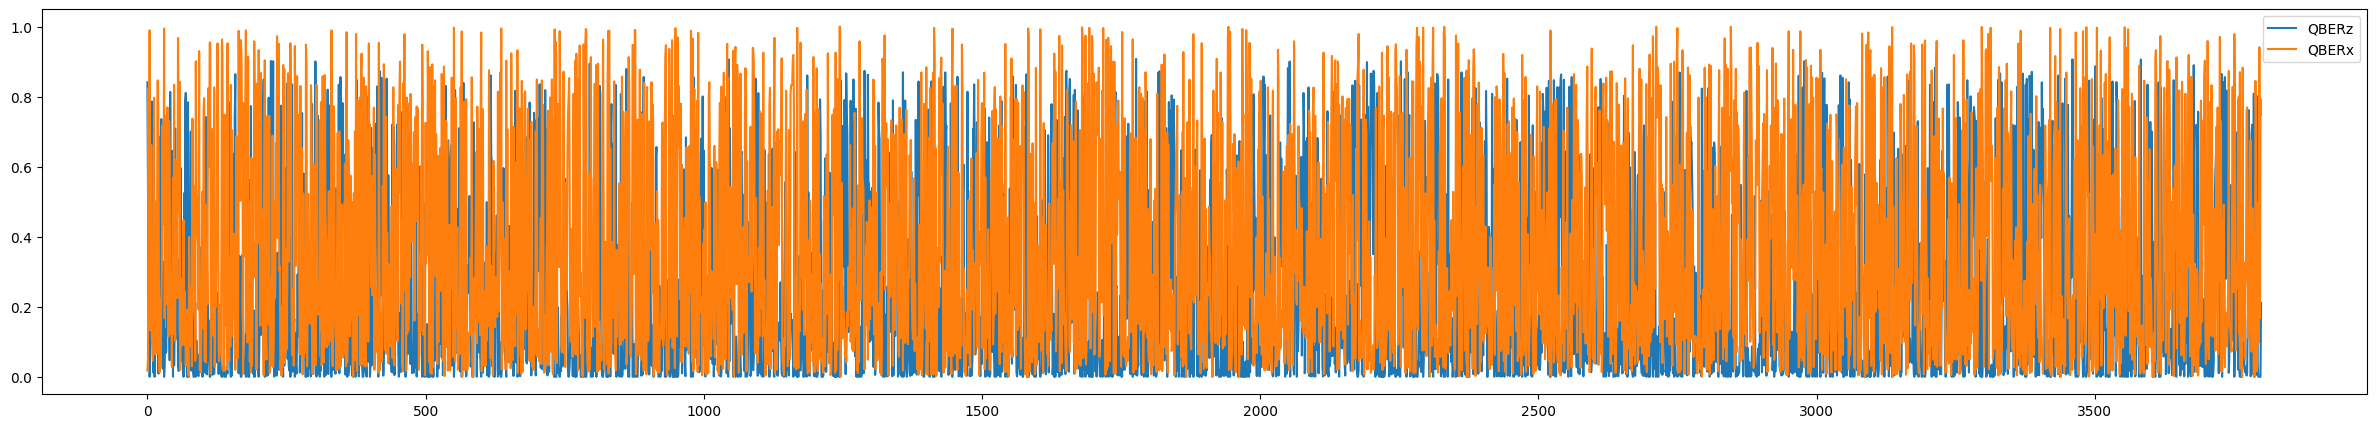

In [3]:
from matplotlib import pyplot as plt
from environment.models.weather_control_fixed import WeatherControlledFixedEnv

env = WeatherControlledFixedEnv(fibre_segments=3)

env.max_steps = 3800
env.reset()
while not env.done:
    env.step()

QBERS = env.get_qber()
plt.figure(figsize=(30, 5))
plt.plot(QBERS)
plt.legend(['QBERz', 'QBERx'])
plt.show()

In [4]:
from data.utils.data_processing import load_historical_weather_data
weather_data = load_historical_weather_data()
n = len(weather_data) - len(QBERS)
weather_data = weather_data.iloc[:-n]

# Check if the length of the weather data and QBER data match
if not len(weather_data) == len(QBERS):
    raise ValueError("Length of weather data and QBER data do not match")

# SARIMA

In [5]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [6]:
# # evaluate an ARIMA model for a given order (p,d,q)
# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out of sample error
#     rmse = sqrt(mean_squared_error(test, predictions))
#     return rmse
 
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = evaluate_arima_model(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except:
#                     continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# # load dataset
# # def parser(x):
# #     return datetime.strptime('190'+x, '%Y-%m')
# # series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# # evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8, 10]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(np.array(QBERS[:,0]), p_values, d_values, q_values)


100%|██████████| 1292/1292 [07:30<00:00,  2.87it/s]


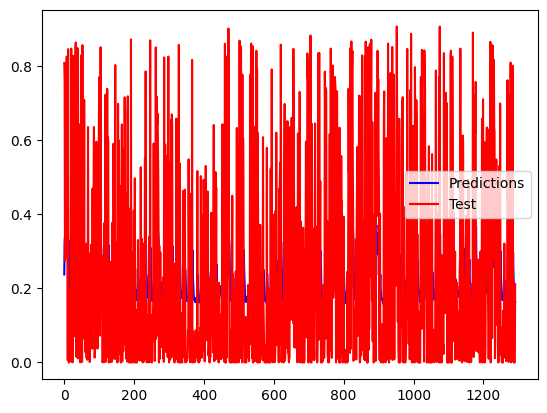

In [9]:
from tqdm import tqdm

X = QBERS[:,0]
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (4,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

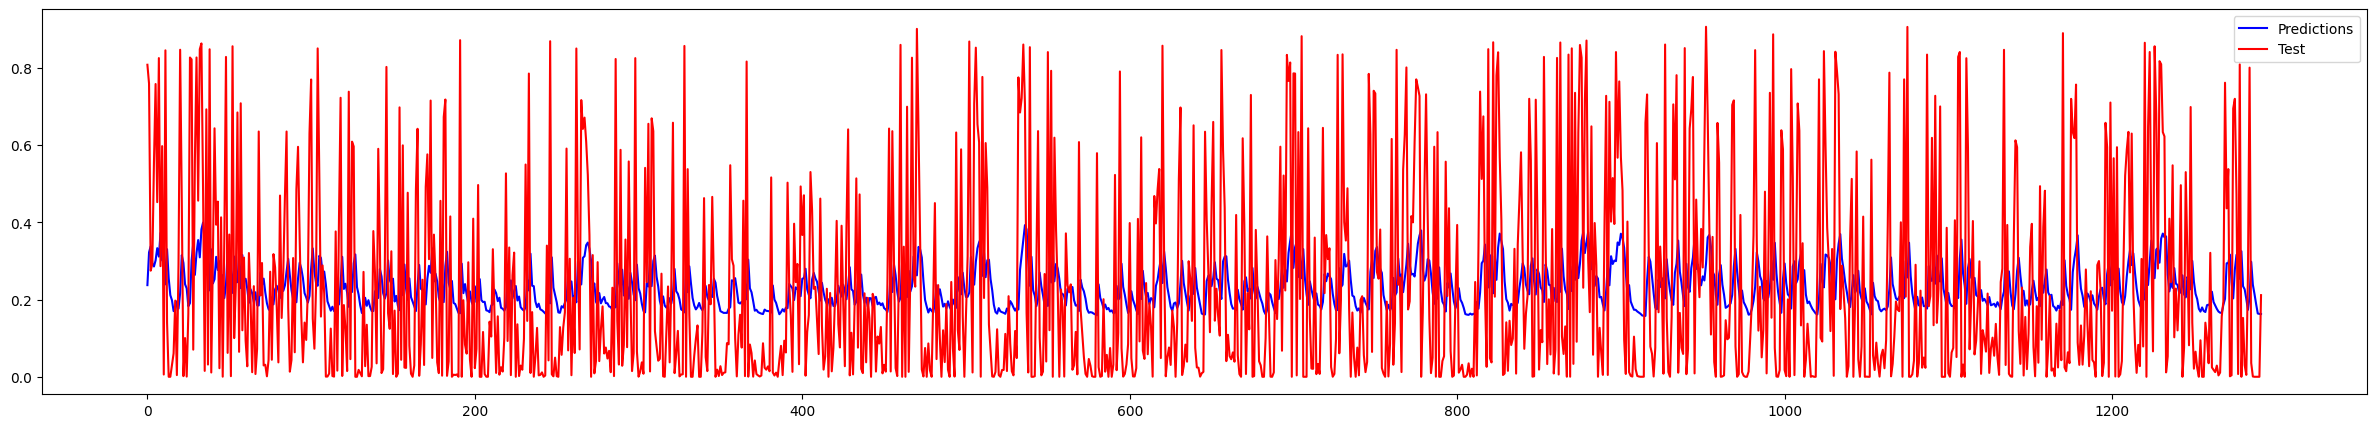

In [11]:
plt.figure(figsize=(30, 5))
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])